# **Example application of the ITCOMPSOM algorithm**
This notebook illustrates the usage of the `ITCOMPSOM` class, which wraps the `Self_Organising_Map` class, and its methods. The iterative completion Self-Organising Map (ITCOMPSOM) method uses Self-Organising Maps (SOMs) to iteratively fill gaps in a given dataset. Progressively larger topological maps are trained on increasingly larger subsets of the input dataset. First, the input dataset is sorted by the number of missing values per sample. Then for a given number of iterations, a subset of the sorted input dataset is selected. A SOM is trained on this subset and afterwards, the missing values are filled using the best-matching units of the respective samples. The missing values are replaced by the corresponding values of the best-matching unit of the SOM. To best-matching unit is determined by using only the available features, which are additionally weighted by the correlation between missing and available features computed beforehand. At the following iteration the newly selected subset then consists of previously completed data and new data still containing missing values. Previously filled values re-filled using the newly trained SOM. Therefore, missing values are filled multiple times until after the last iteration all missing values in the input dataset are filled using the final SOM. In the last step, the now filled dataset is reorderd to its original sample order. This method has successfully been applied to various datasets, including glider data (Charantonis et al., 2015), deep current velocities (Chapman & Charantonis, 2017), the vertical distribution of phytoplankton in the water column (Puissant et al., 2021), and a mooring array in the East Australian Current (Sloyan et al., 2023).

The workflow of how to use the `ITCOMPSOM` class is illustrated in the following on an example dataset. Generally, the workflow follows three basic steps:
1. The `ITCOMPSOM` object is initialised
2. The data is pre-processed, i.e. normalising the dataset and ordering it by the number of missing values per sample
3. The iterative process of filling the gaps is performed

> Chapman, C. & Charantonis, A. A. (2017). Reconstruction of Subsurface Velocities From Satellite Observations Using Iterative Self-Organizing Maps. *IEEE Geoscience and Remote Sensing Letters, 14 (5)*, 617–620. doi:[10.1109/LGRS.2017.2665603](https://www.doi.org/10.1109/LGRS.2017.2665603)
>
> Charantonis, A. A.; Testor, P.; Mortier, L.; D’Ortenzio, F. & Thiria, S. (2015). Completion of a Sparse GLIDER Database Using Multi-iterative Self-Organizing Maps (ITCOMPSOM). *Procedia Computer Science, 51*, 2198–2206. doi:[10.1016/j.procs.2015.05.496](https://www.doi.org/10.1016/j.procs.2015.05.496)
>
> Puissant, A.; El Hourany, R.; Charantonis, A. A.; Bowler, C. & Thiria, S. (2021). Inversion of Phytoplankton Pigment Vertical Profiles from Satellite Data Using Machine Learning. *Remote Sensing, 13 (8)*. doi:[10.3390/rs13081445](https://www.doi.org/10.3390/rs13081445)
>
> Sloyan, B. M.; Chapman, C. C.; Cowley, R. & Charantonis, A. A. (2023). Application of Machine Learning Techniques to Ocean Mooring Time Series Data. *Journal of Atmospheric and Oceanic Technology, 40 (3)*, 241–260. doi:[10.1175/JTECHD-21-0183.1](https://www.doi.org/10.1175/JTECHD-21-0183.1)

In [1]:
import numpy as np
import xarray as xr
from itcompsom_routines import (
    Scaler,
    ITCOMPSOM
)
from pathlib import Path
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

## The example dataset
To illustrate the usage of the `ITCOMPSOM` class, a dataset consisting of ten sine waves is used. Each sine wave represents a feature and contains between $5\%$ to $15\%$ of missing data. The missing data points are distributed randomly across the samples, as well as consecutively to form larger gaps in the data.

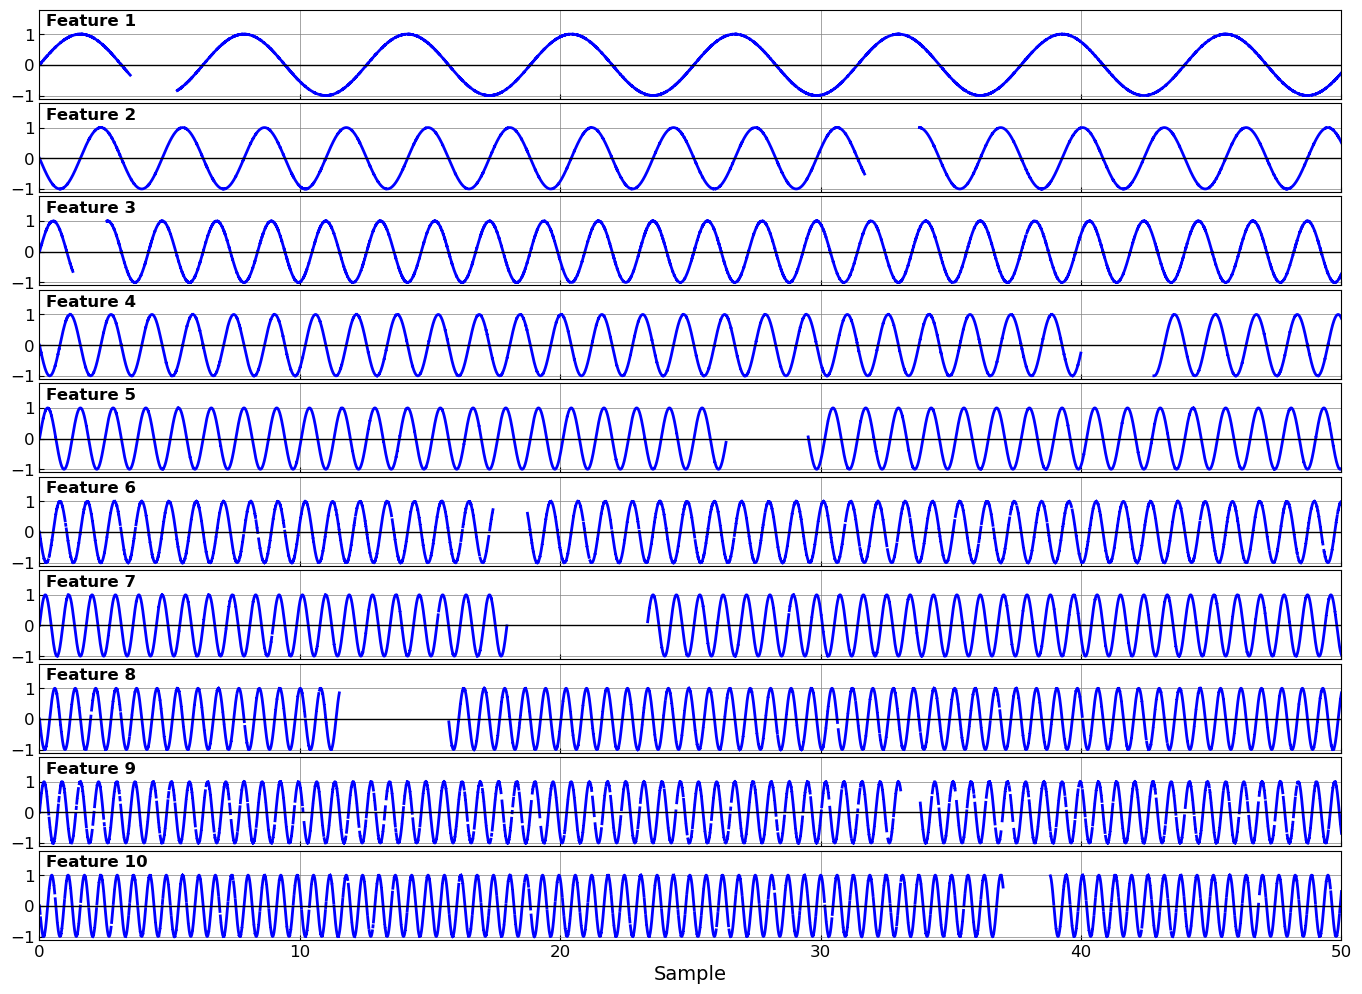

In [2]:
# Load sample data into memory and set flagged data to NaN.
sample_data = xr.open_dataset("sample_data.nc")
sample_data = sample_data.assign({
    "signal_masked" : sample_data.signal.where(sample_data.flagged == False)
})
# The sample dataset consists of several sine waves, each having between 5%
# and 15% of missing data. Some of the missing data forms consecutive blocks,
# while some of the data is missing randomly.
fig, axes = plt.subplots(
    figsize = (14, 10),
    nrows = 10,
    ncols = 1
)
fig.subplots_adjust(
    top = 0.98,
    bottom = 0.05,
    left = 0.05,
    right = 0.98,
    hspace = 0.05
)
for i, ax in enumerate(axes, start = 1):
    ax.plot(
        sample_data.sample,
        sample_data.signal_masked.sel(feature = i),
        color = "blue",
        linewidth = 2
    )
    if i < 10:
        ax.tick_params(labelbottom = False)
    else:
        ax.set_xlabel(
            "Sample",
            fontsize = 14
        )
    ax.tick_params(
        direction = "in",
        labelsize = 12
    )
    ax.set_xlim(0., 50.)
    ax.set_ylim(-1.1, 1.8)
    ax.grid(
        color = (0.5, 0.5, 0.5),
        linewidth = 0.5
    )
    ax.axhline(
        y = 0.,
        color = "black",
        linewidth = 1
    )
    ax.annotate(
        f"Feature {i}",
        xy = (0, 1),
        xycoords = "axes fraction",
        xytext = (5, -3),
        textcoords = "offset points",
        fontsize = 12,
        fontweight = "bold",
        verticalalignment = "top",
        horizontalalignment = "left"
    )

## Filling in missing data
The ITCOMPSOM method saves the results after each iteration. This can be used to, for example, interupt the process and continue from the last iteration. The results are stored in a location specified by the user and can either be kept for later use, or automatically deleted after the following iteration is finished.

Here, a hexagonal, toroidal grid is chosen. The size of the initial topological map is set to approximately $100$, while the final SOM has a size of approximately $1,500$ grid cells. Following Vatanen et al. (2015), the shape of the topological map, i.e. the number of rows and columns, is determined by the ratio between the two largest eigenvalues of the input dataset. Over the course of ten iterations, the gaps in the example dataset are filled, where the number of epochs and the neighbourhood radii are identical for each iteration. Here, the training is separated into a rough and a fine training phase. During the former, the neighbourhood radii are larger and are subject to a faster decay per epoch, while they are smaller with a slower decay during the latter.

> Vatanen, T.; Osmala, M.; Raiko, T.; Lagus, K.; Sysi-Aho, M.; Orešic, M.; Honkela, T. & Lähdesmäki, H. (2015). Self-organization and missing values in SOM and GTM. *Neurocomputing, 147*, 60–70. doi:[10.1016/j.neucom.2014.02.061](https://www.doi.org/10.1016/j.neucom.2014.02.061)

In [3]:
# First, the ITCOMPSOM object is initialised. Since the dataset is quite
# small, no dask cluster and chunking of the dataset is necessary.
itcompsom = ITCOMPSOM(
    f_chunk_size = "auto",
    f_dask_cluster = None,
    f_temporary_output = {
        "path" : Path("temporary_output"),
        "delete" : True
    },
    f_random_state = 12345,
    f_verbose = 1
)
# Next, the input data is pre-processed, i.e. each feature in the dataset is
# normalised by its variance.
itcompsom.preprocessing(
    f_data = sample_data.signal_masked,
    f_norm_dim = "sample",
    f_norm_method = "variance"
)
# The ITCOMPSOM process is performed, where the type of lattice is chosen, the
# approximate initial and final sizes of the lattice, the number of iterations
# of the gap filling process, as well as the training parameters for the SOM.
# At each iteration a SOM is trained according to these parameters. In this
# case, each SOM is trained for 20 epochs with an initial neighbourhood radius
# of 20 and a final radius of 1. After each iteration the size of the SOM is
# increased.
filled_data = itcompsom.run(
    f_lattice = "hexa",
    f_shape = "toroid",
    f_SOM_size = (100, 1_500),
    f_num_iterations = 10,
    f_training_params = [
        {"epochs" : 5, "radius" : {"s1" : 100., "s0" : 25., "b" : None}},
        {"epochs" : 20, "radius" : {"s1" : 25., "s0" : 1., "b" : None}},
    ]
)

ITCOMPSOM: 100%|█████████████████████████████████████| 10/10 [12:05<00:00, 72.51s/it]


## Evaluating the performance
To evaluate the performance of the gap filling process, additional artificial gaps need to be introduced. In this illustration, this is not necessary, since the true signal is available.

For the randomly missing data points, three parameters are computed to assess the accuracy of the predicted values. The respective parameters are the root mean square error (RMSE), the coefficient of determination ($r^2$), and the slope of a linear fit through the scatter plot of predicted values over true values. For larger data gaps the mean residual between predicted and true values is computed.

<font color="red">**Note of caution:**</font> This notebook only illustrates the usage of the `ITCOMPSOM` class and examples of how to evaluate the results. Applying this method to a dataset requires careful hyperparameter tuning (number of SOM classes, number of iterations, training epochs, and neighbourhood radii). The gaps in the dataset should be reliably filled, but the model should not overfit the training data. To test the model for overfitting, the trained SOM after the last iteration can be used to predict random data points that were used in the training process. If the RMSE is of similar magnitude between the data used in the training process and previously unseen values, this suggests, that the model does not overfit the training data.

In [4]:
# To evaluate the performance of the gap filling process, only the values that
# where filled by the algorithm are necessary.
filled_data = xr.Dataset(
    data_vars = {
        "continuous" : filled_data.where(sample_data.flagged_continuous),
        "random" : filled_data.where(sample_data.flagged_random)
    },
    coords = filled_data.coords
)
# For the randomly missing data points, the root mean square error, the
# coefficient of determination, and the slope between the true and filled
# values is estimated.
validation_params = xr.Dataset(
    data_vars = {
        "RMSE" : np.sqrt((
            (sample_data.signal - filled_data.random) ** 2.
        ).mean(dim = "sample")),
        "r2" : xr.corr(
            sample_data.signal,
            filled_data.random,
            dim = "sample"
        ) ** 2.,
    },
    coords = {"feature" : sample_data.feature}
)
validation_params = validation_params.assign({
    "slope" : xr.apply_ufunc(
        lambda X, Y, deg : np.polyfit(X[np.isfinite(Y)], Y[np.isfinite(Y)], deg = deg),
        sample_data.signal,
        filled_data.random,
        kwargs = {"deg" : 1},
        input_core_dims = [["sample"], ["sample"]],
        output_core_dims = [["deg"]],
        exclude_dims = set(("sample", )),
        vectorize = True
    ).assign_coords({
        "deg" : (("deg", ), [1, 0])
    })
})
# For the continuously missing data points, the mean residual between the true
# and filled values is computed.
validation_params = validation_params.assign({
    "mean_residual" : (
        sample_data.signal
        - filled_data.continuous
    ).mean(dim = "sample")
})

The following plot shows scatter plots of the predictions over the true values of the randomly missing data points for each feature. Also indicated in each panel are the RMSE, $r^2$, and the slope of the linear fit through the data points. this provides an overview of the accuracy with which randomly missing data points are predicted.

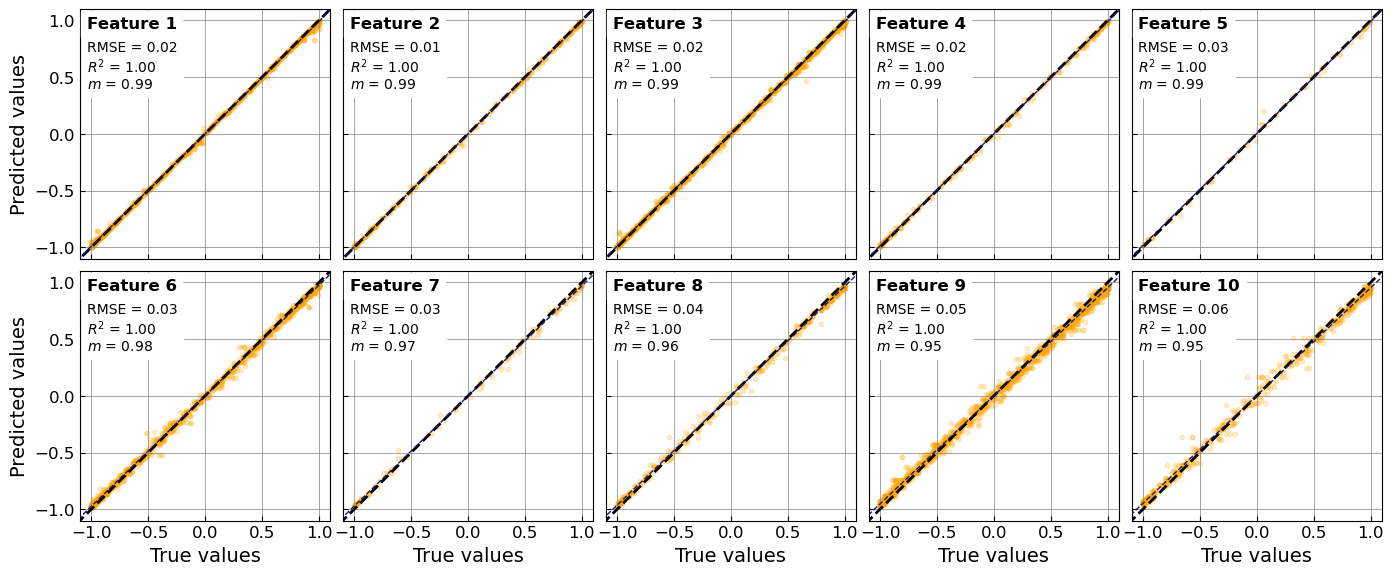

In [5]:
fig, axes = plt.subplots(
    figsize = (14, 5.5),
    ncols = 5,
    nrows = 2
)
fig.subplots_adjust(
    top = 0.98,
    bottom = 0.05,
    left = 0.05,
    right = 0.98,
    hspace = 0.05,
    wspace = 0.05
)
for i, ax in enumerate(axes.ravel(), start = 1):
    ax.scatter(
        sample_data.signal.sel(feature = i),
        filled_data.random.sel(feature = i),
        s = 10,
        color = "orange",
        alpha = 0.2
    )
    ax.plot(
        [-2., 2.], [-2., 2.],
        color = "black",
        linestyle = "--",
        linewidth = 2,
        zorder = 4
    )
    ax.plot(
        [-2., 2.],
        np.poly1d(validation_params.slope.sel(feature = i))([-2., 2.]),
        color = "midnightblue",
        linewidth = 1,
        linestyle = "--",
        zorder = 5
    )
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    if (i - 1) // 5 == 0:
        ax.tick_params(labelbottom = False)
    else:
        ax.set_xlabel(
            "True values",
            fontsize = 14
        )
    if (i - 1) % 5 > 0:
        ax.tick_params(labelleft = False)
    else:
        ax.set_ylabel(
            "Predicted values",
            fontsize = 14
        )
    ax.tick_params(
        direction = "in",
        labelsize = 12
    )
    ax.grid(
        color = (0.5, 0.5, 0.5),
        linewidth = 0.5
    )
    rmse = float(validation_params.RMSE.sel(feature = i))
    r2 = float(validation_params.r2.sel(feature = i))
    slope = float(validation_params.slope.sel(feature = i, deg = 1))
    label = (
        f"RMSE = {rmse:.2f}\n"
        r"$R^2$ = " + f"{r2:.2f}\n"
        r"$m$ = " + f"{slope:.2f}"
    )
    ax.annotate(
        f"Feature {i}",
        xy = (0, 1),
        xycoords = "axes fraction",
        xytext = (5, -5),
        textcoords = "offset points",
        fontsize = 12,
        fontweight = "bold",
        backgroundcolor = "white",
        verticalalignment = "top",
        horizontalalignment = "left"
    )
    ax.annotate(
        label,
        xy = (0, 1),
        xycoords = "axes fraction",
        xytext = (5, -22),
        textcoords = "offset points",
        fontsize = 10,
        backgroundcolor = "white",
        horizontalalignment = "left",
        verticalalignment = "top",
        zorder = 2
    )

The next plot shows the predicted (red) and true (blue) values of the continuous data gaps. Included in each panel is the mean residual between the two curves. This allows to assess the prediction skill for larger data gaps.

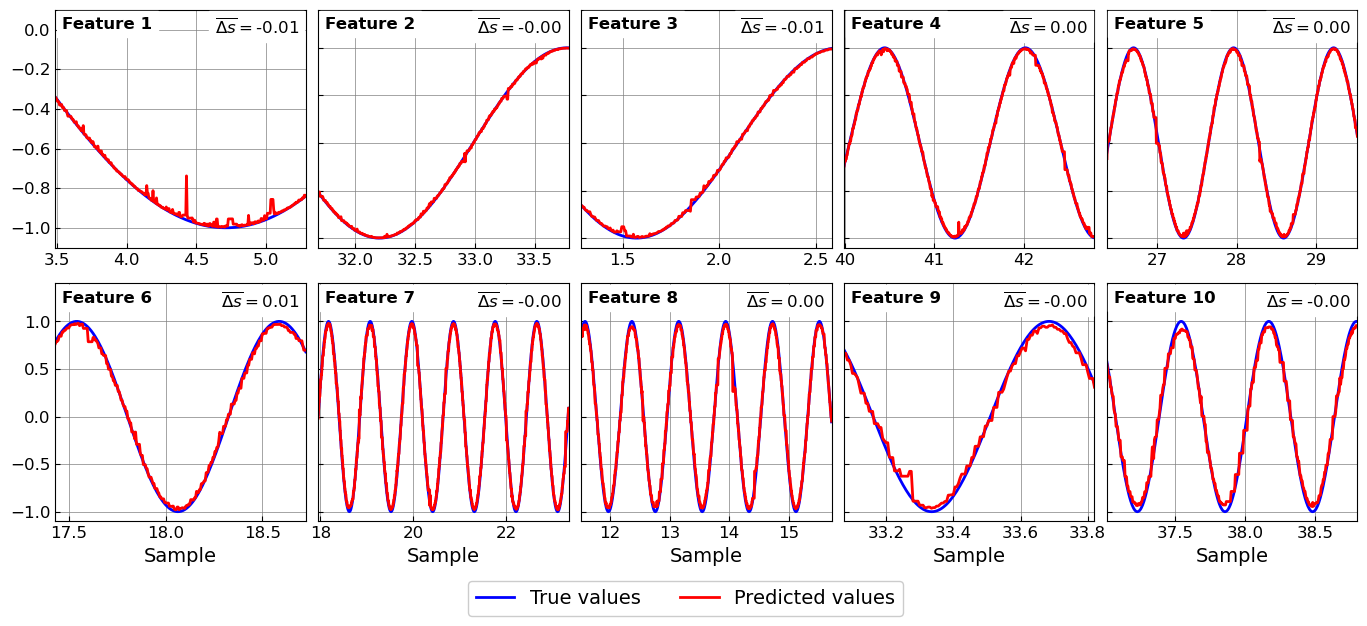

In [6]:
fig, axes = plt.subplots(
    figsize = (14, 5.5),
    ncols = 5,
    nrows = 2
)
fig.subplots_adjust(
    top = 0.98,
    bottom = 0.05,
    left = 0.05,
    right = 0.98,
    hspace = 0.15,
    wspace = 0.05
)
for i, ax in enumerate(axes.ravel(), start = 1):
    filled = filled_data.continuous.sel(feature = i).dropna(dim = "sample")
    original = sample_data.signal.sel(feature = i).sel(sample = filled.sample)
    ax.plot(
        original.sample,
        original,
        color = "blue",
        linewidth = 2
    )
    ax.plot(
        filled.sample,
        filled,
        color = "red",
        linewidth = 2
    )
    ax.set_xlim(filled.sample.min(), filled.sample.max())
    ax.set_ylim(
        np.floor(original.min() * 10.) / 10. - 0.1,
        np.ceil(original.max() * 10.) / 10. + 0.4
    )
    if (i - 1) // 5 == 1:
        ax.set_xlabel(
            "Sample",
            fontsize = 14
        )
    if (i - 1) % 5 > 0:
        ax.tick_params(labelleft = False)
    ax.tick_params(
        direction = "in",
        labelsize = 12
    )
    ax.grid(
        color = (0.5, 0.5, 0.5),
        linewidth = 0.5
    )
    ax.annotate(
        f"Feature {i}",
        xy = (0, 1),
        xycoords = "axes fraction",
        xytext = (5, -5),
        textcoords = "offset points",
        fontsize = 12,
        fontweight = "bold",
        backgroundcolor = "white",
        verticalalignment = "top",
        horizontalalignment = "left"
    )
    ax.annotate(
        (
            r"$\overline{\Delta s} = $"
            + f"{float(validation_params.mean_residual.sel(feature = i)):.2f}"
        ),
        xy = (1, 1),
        xycoords = "axes fraction",
        xytext = (-5, -5),
        textcoords = "offset points",
        fontsize = 12,
        backgroundcolor = "white",
        horizontalalignment = "right",
        verticalalignment = "top"
    )
fig.legend(
    handles = (
        Line2D([0], [0], color = "blue", linewidth = 2),
        Line2D([0], [0], color = "red", linewidth = 2)
    ),
    labels = ("True values", "Predicted values"),
    ncols = 2,
    loc = "lower center",
    bbox_to_anchor = (0.5, -0.14),
    fontsize = 14,
    framealpha = 1
);